# Introduction to Data Science with Anime DVD/BD Sales

CMSC 320 Final Tutorial

Author: Chenqi Zhu

# Introduction

Greetings, readers! This tutorial covers the *Introduction to Data Science* pipeline and will walk you through the process from acquiring data online to Machine Learning techniques using the data of Anime DVD/BD Sales. Before we start getting our hands on the data, let's first get to know what exactly is Anime DVD/BD Sales.

# Background

Anime is a popular Japanese media that refers to any animated shows that are produced in Japan. In the west, People often use the word 'Anime' to describe what truly is 'Midnight Anime', which are animated shows that are broadcasted during midnight on Japanese television channels. Being broadcasted during midnight means the show cannot rely on commercials for revenues, resulting in the production company heavily depends on the DVD, later Blu-ray, sales to generate income. This unique business model makes the DVD/BD sales a crucial indicator of popularity, profitability, success, quality, etc., for an anime. Therefore, I would like to explore the data relating to the Anime DVD/BD Sales and see they are influenced by what kind of factors.

To learn more on the importance of Anime DVD/BD Sales:https://www.someanithing.com/sales-faqguide

There are various libraries that we will need throughout the tutorial, I'll introduce them when we use them. For now, let's import them first.

In [1]:
# Necessary imports
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import LinearRegression
from IPython.display import display, Math
from scipy import stats
from sklearn.cluster import KMeans
import sys
import seaborn as sns


# Data Collection and Parsing
As you may have guessed, the statistics on Anime DVD/BD sales in Japan are written in Japanese; moreover, it is also locked behind a paywall. Thankfully, the English anime community has organized the same statistics in English on the site https://www.someanithing.com/ . We will be using web-scrapping technique to get the data from there.

On this website, the data for Anime DVD/BD Sales before and after the year 2000 are stored on two different pages. Thus we will perform the following tasks twice on two different web page: https://www.someanithing.com/series-data-quick-view for data after 2000 and https://www.someanithing.com/312 for data before 2000.

To scrape a website, we'll first using `requests` library and its `get()` function to get an 'object' that contains the information returned by the web server. This 'object' would contain many fields, from which we only need the raw text of the web page. We can parse the raw text to readable html text using `BeautifulSoup`. Because the website is dedicated to anime sales statistics, the data we want is already listed as html table. By calling `fin('table')`, we can directly get the table containing anime sales data.

Both requests and BeautifulSoup are helpful library in web-scrapping, since this is not *Introduction to Web Scrapping* I would not thoroughly explain them. You can read their documentations at https://docs.python-requests.org/en/master/ and https://www.crummy.com/software/BeautifulSoup/bs4/doc/ .

After we have the table, we will read it to a pandas dataframe by calling `pd.read_html()`. Pandas is a powerful data analysis tool, and we will be using many of its features for this tutorial. To learn more on pandas https://pandas.pydata.org/ . 

In [2]:
# Obtain data from website  
url1 = requests.get("https://www.someanithing.com/series-data-quick-view")
url2 = requests.get("https://www.someanithing.com/312")

# Parse the raw text with BS
soup1 = BeautifulSoup(url1.text, "html.parser")
soup2 = BeautifulSoup(url2.text, "html.parser")

# Find the table we want, luckily there's only one table we want on each page
# so no need to manually check it.
table1 = soup1.find('table')
table2 = soup2.find('table')

# Read the data into pandas dataframe
data1 = pd.read_html(str(table1))
data2 = pd.read_html(str(table2))

# anime_aft_2000 for Anime DVD/BD Sales after 2000
# anime_bfr_2000 for Anime DVD/BD Sales after 2000
anime_aft_2000 = data1[0]
anime_bfr_2000 = data2[0]

In [3]:
# Take a peak at the dataframe, it is indeed what we want.
anime_aft_2000.head()

,Title,Year,Season,Avg Sales,Re-rls,Total,Gross in ¥1m (1st rls only),Studio,Source
0,.hack//SIGN,2002,Spring,6032,0,6032,¥362.2,Bee Train,game
1,.hack//Tasogare no Udewa Densetsu,2003,Winter,2954,0,2954,¥102.8,Bee Train,game
2,.hack//Roots,2006,Spring,2138,0,2138,¥113.0,Bee Train,game
3,009-1,2006,Fall,1258,0,1258,¥46.4,Ishimori Entertainment,manga
4,07-Ghost,2009,Spring,2529,0,2529,¥197.2,Studio Deen,manga


In [4]:
anime_bfr_2000.head()

,Title,Year,Avg Sales,Re-rls,Mixed Re-rls,Total,Studio
0,∀Gundam,1999,7107.0,12607.0,999.0,20713,Sunrise
1,Aa! Megami-sama!: Chichaitte Koto wa Benri da ne,1998,3201.0,NaN,NaN,3201,Oriental Light and Magic
2,Aesop World,1999,NaN,NaN,NaN,0,Sunrise
3,Ai Tenshi Densetsu Wedding Peach,1995,NaN,NaN,NaN,0,"Oriental Light and Magic, KSS"
4,Aka-chan to Boku,1996,NaN,NaN,NaN,0,Studio Pierrot


# Data Management

## Joining Datasets

As you can see, the data for Anime DVD/BD Sales before the year 2000 contains much more missing data. Furthermore, the dataframe for Anime DVD/BD Sales before 2000 has less columns than the dataframe for after 2000. This is simply due to the fact that the DVD was invented in 1997 and the Anime industry prior to 2000 counted more on VHS sales, which we would not explore. 

Despite this, the Anime DVD/BD Sales before 2000 contains some crucial data that we would like to include in our later analysis. In fact, the best-selling anime of all time, *Neon Genesis Evangelion*, is included only in the before 2000 dataframe. So, we will combine these two dataframes.

To join two dataframe, we can call the function `merge()`. Since *anime_aft_2000* has more columns, we will merge *anime_bfr_2000* to *anime_aft_2000* and use outer join, which keeps all the rows from the two dataframe. The reason I choose this type of join is that I want to keep the data as complete as possible when creating the dataframe so that we will have sufficient information to know how to treat the data that is missing. Although some columns contain significant amount of missing data, we may not be looking at those columns. We will talk about how to treat the specific missing data when we encounter them.

In [5]:
# Merge the two dataframes
anime_sales = anime_aft_2000.merge(anime_bfr_2000,how = 'outer')

# This dataframe will be the one we explore.
anime_sales.head()

,Title,Year,Season,Avg Sales,Re-rls,Total,Gross in ¥1m (1st rls only),Studio,Source,Mixed Re-rls
0,.hack//SIGN,2002,Spring,6032.0,0.0,6032,¥362.2,Bee Train,game,NaN
1,.hack//Tasogare no Udewa Densetsu,2003,Winter,2954.0,0.0,2954,¥102.8,Bee Train,game,NaN
2,.hack//Roots,2006,Spring,2138.0,0.0,2138,¥113.0,Bee Train,game,NaN
3,009-1,2006,Fall,1258.0,0.0,1258,¥46.4,Ishimori Entertainment,manga,NaN
4,07-Ghost,2009,Spring,2529.0,0.0,2529,¥197.2,Studio Deen,manga,NaN


## Treating Missing Items

Above is a peak at the dataframe we will be exploring, before we start, let me explain how to interpret each column and how to treat missing data in specific columns.

The *Title*, as the name suggests, is the tile for each show. 

Anime broadcasting is not only categorized by *Year* but also by *Season*, which is analogous to four natural seasons. Since the season is rather irrelevant and is missing for titles prior to 2000, we will only look at the year.

*Avg Sales* is the DVD/BD sales per volume. Anime DVD/BDs are sold by volumes for about 60 dollars a volume. Sometimes the production company would resell the DVD/BDs after the show has ended for a period of time to, to put it simply, make more money, therefore the *Re-rls* column for re-release. We will be only looking at *Total* which is the combined sales of average sales and re-release. 

Based on my expertise, the data for total sales can only be missing when the sales are so low that it is not counted my retailers. This also means they are **Missing Not At Random**. So, I'll replace any `NaN` in *Total* with 0.

*Gross* is the revenue for each show. This, despite its name, is a bad indicator for anime sales because it is a rough estimate based on disc sales and is not accounted for inflation. Different shows also have different length, a shorter show might sell more DVDs but had a lower revenue than a longer worse-selling show. On the other hand, the DVD/BD sales is always sold at a constant price of approximately $60 per volume in today's dollar. Thus, again, we will only look at *Total*. 

*Studio* is the company that made the show and *Source* is the material from which the show is adapted, some shows are adapted from manga or games, like *Attack on Titan*, others are original.

Data is missing in *Source* column because the statistic on the website does not provide source for titles from before 2000, which is **Missing At Random**. Note that in anime not having a source means the show is original, and I can guarantee not all shows from before 2000 are original, thus we cannot plainly treat them as not having sources. In theory I can mark their sources manually but that is a consuming work. I will replace the `NaN` in *Source* with the word *vintage* to suggest they are vintage shows whose sources are not recorded in the data.

We can replace entries in a column by calling `replace()` 

In [6]:
# Treat missing data
# Replace NaN in Total with 0
anime_sales['Total'] = anime_sales['Total'].replace(np.nan,0)
# Replace NaN in Source with vintage
anime_sales['Source'] = anime_sales['Source'].replace(np.nan,'vin·tage')

The `anime_sales` dataframe will be the final dataframe.

Now that we have tidied our dataframe, we will continue to explore it.

In [7]:
anime_sales.head()

,Title,Year,Season,Avg Sales,Re-rls,Total,Gross in ¥1m (1st rls only),Studio,Source,Mixed Re-rls
0,.hack//SIGN,2002,Spring,6032.0,0.0,6032,¥362.2,Bee Train,game,NaN
1,.hack//Tasogare no Udewa Densetsu,2003,Winter,2954.0,0.0,2954,¥102.8,Bee Train,game,NaN
2,.hack//Roots,2006,Spring,2138.0,0.0,2138,¥113.0,Bee Train,game,NaN
3,009-1,2006,Fall,1258.0,0.0,1258,¥46.4,Ishimori Entertainment,manga,NaN
4,07-Ghost,2009,Spring,2529.0,0.0,2529,¥197.2,Studio Deen,manga,NaN


# Exploratory data analysis

For this section, I will try to make some graphs that perhaps will provide us some insight on what factors are affecting the sales of anime DVD/BD(for the sake of simplicity I'll call them just DVD).  

The first thing I want to see is whether year is affecting the sales of anime. This is a reasonable guess because time affects many things, the sales may be going up or down as time goes on. There are many shows sold in each year, blindly calculating the average may become a problem because a few shows with 0 sales could heavily skew the mean. Instead, I want the graph to show the distribution of sales in each year.

A good way to achieve this is to do a violin plot of anime sales for each year. Violin plot is a plotting method that shows the density of values on each side, which makes it looks like a violin.

In [8]:
# Before plotting I have to convert the values in dataframe 
# to a dictionary for the plot to work

# This dictionary will have the year as keys and list of sales as values
# Again the numbers in the Total column is the sales we are looking at

# First create an empty dictionary and iterate over the dataframe to
# add key-value pairs
year_sales_dict = {}
for index, row in anime_sales.iterrows():
    if row['Year'] in year_sales_dict:
        year_sales_dict[row['Year']].append(row['Total'])
    else:
        year_sales_dict[row['Year']] = []
        year_sales_dict[row['Year']].append(row['Total'])

Next we can plot the graph. 

We will use the `matplotlib` library to plot our graphs. This library is very popular for plotting and graphing in python and you can learn more about it at https://matplotlib.org/stable/contents.html .

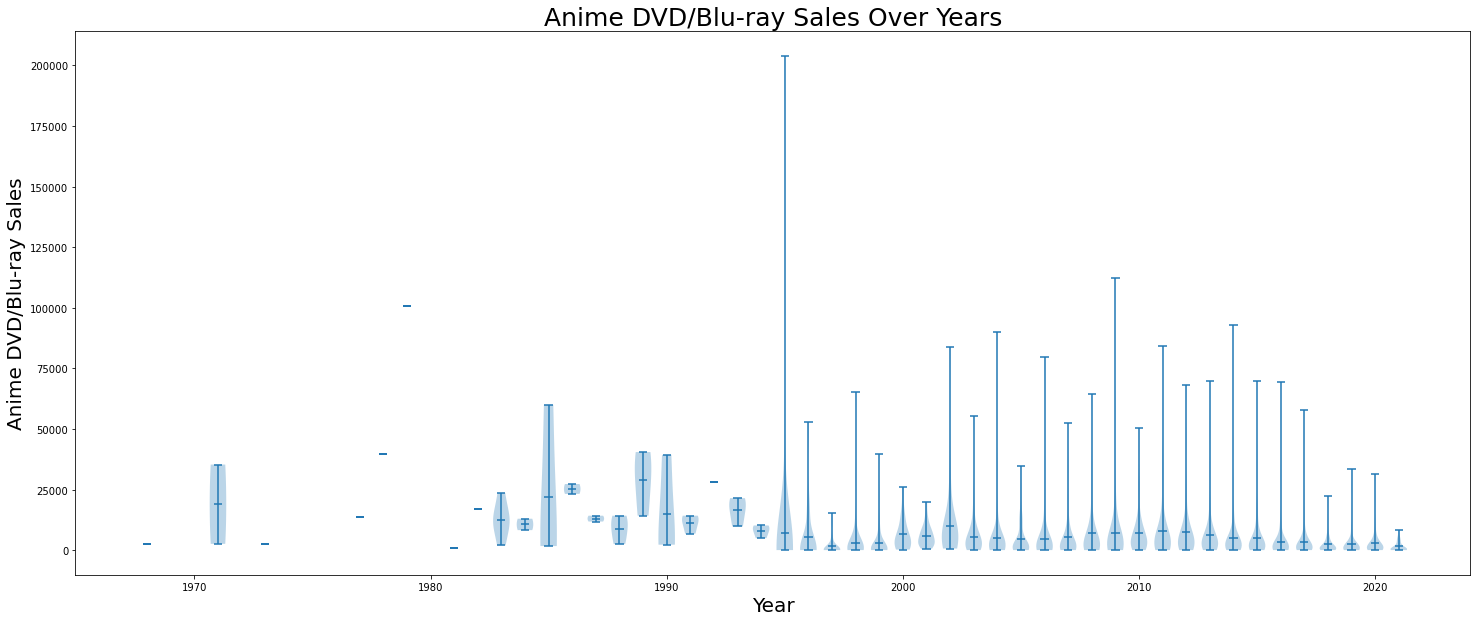

In [9]:
# Vionlin Plot DVD sales against year
# Initialize plot
fig, ax = plt.subplots()
# Set graph size
fig.set_size_inches(25, 10)
# Plot the graph
# Convert the dictionary to lists
ax.violinplot(list(year_sales_dict.values()),list(year_sales_dict.keys()),widths=.7,showmeans=True)
# Set lables
ax.set_xlabel('Year', fontsize=20)
ax.set_ylabel('Anime DVD/Blu-ray Sales', fontsize=20)
ax.set_title('Anime DVD/Blu-ray Sales Over Years', fontsize=25)
plt.show() 

As the graph shown above. We can see the sales prior to 1995 are sporadic. This is because, again, DVD was not invented back then, and those sales are re-releases. These irregular sales prevent us from gaining more insight about the relationship between year and sales. Thus, we would like a graph focused only on shows broadcasted since 1995.

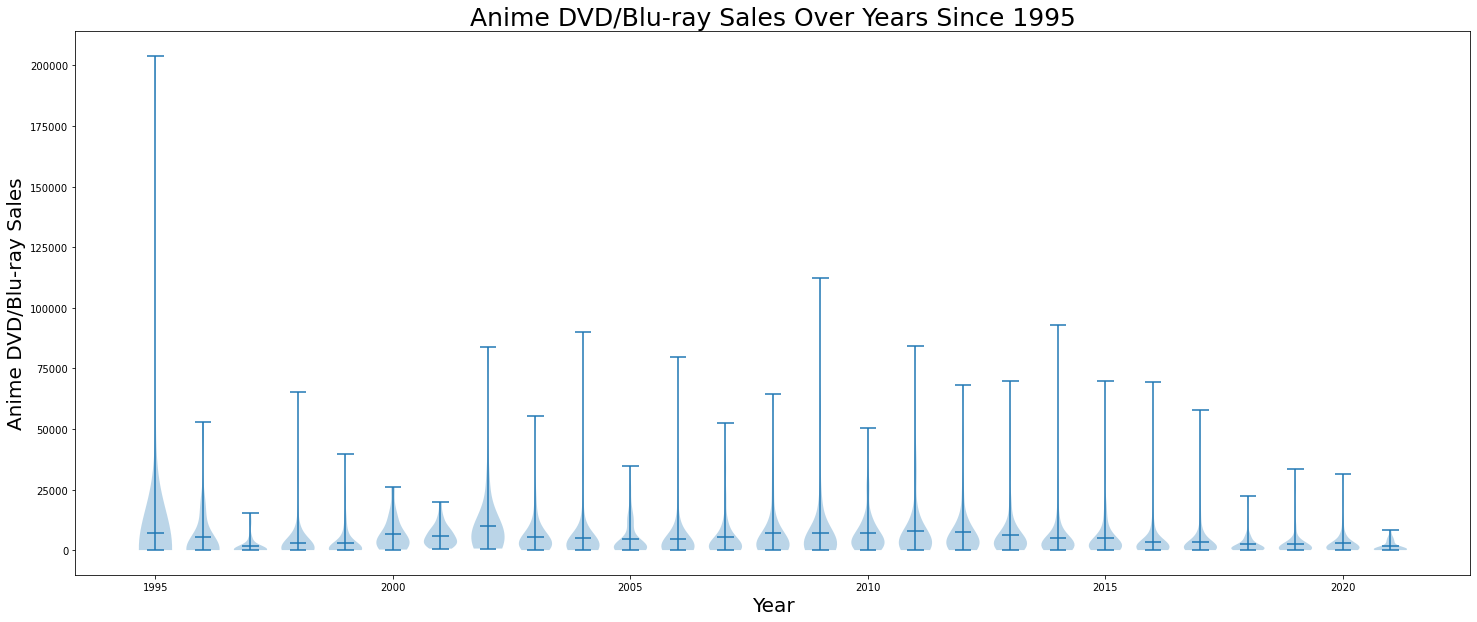

In [10]:
# This one line code allows us to filter a dictionary based on key
year_sales_dict_after1995 = { key:value for (key,value) in year_sales_dict.items() if key > 1994}

# Next plot using this new dictionary

# Vionlin Plot DVD sales against year
# Initialize plot
fig, ax = plt.subplots()
# Set graph size
fig.set_size_inches(25, 10)
# Plot the graph
# Convert the dictionary to lists
ax.violinplot(list(year_sales_dict_after1995.values()),
              list(year_sales_dict_after1995.keys()),
              widths=.7,
              showmeans=True)
# Set lables
ax.set_xlabel('Year', fontsize=20)
ax.set_ylabel('Anime DVD/Blu-ray Sales', fontsize=20)
ax.set_title('Anime DVD/Blu-ray Sales Over Years Since 1995', fontsize=25)
plt.show() 

This graph offers us more insights about anime DVD sales across years. 

We can see despite a high upper outlier; most shows have sales under 20,000 and number seems to be stable but slightly decreasing over the years. For almost every year there are a selected few show that were sold much more than their peers. And if we ignore the outliers, the sales in each year have a Hershey's chocolate shape. This discovery is consistent with my knowledge about the industry.

If year is indeed a factor that is affecting DVD sales, it is possible for us to create a model that could predict DVD sales based on the year. 

In the next section, I will try to create a Linear Regression model that predicts anime DVD sales based on year, and conduct hypothesis test to see if my model is accurate.

# Linear Regression and Hypothesis Test

## Linear Regression

Linear regression is a statistical approach to modeling the relationship between a result and other variables. It minimizes the error between prediction and actual value. If we created a linear regression model using year as variable and sales as result, we could predict sales by passing year to this model as input.

The `sklearn` library included an efficient algorithm to create linear regression model.
We will use that to create a linear model between year and anime DVD sales.

To learn more about scikit learn's linear regression model, at https://scikit-learn.org/stable/modules/linear_model.html .

In [11]:
# We are going to create the lists of x values and y values using 
# the dictionary we used ealier
# x_list will contain years
# y_list will contain sales
x_list = []
y_list = []
for (key,value) in year_sales_dict_after1995.items():
    for sale in value:
        x_list.append(key)
        y_list.append(sale)

# Create model using Scikit-Learn
model_ys = LinearRegression()

# We have to reshape x values list to 2D array to use sklearn model
x_list = np.array(x_list).reshape(-1, 1)

# Fit data using linear regression model
model_ys.fit(x_list, y_list)

# Get the coefficient and intercept of the linear equation
m = model_ys.coef_[0]
b = model_ys.intercept_

# Print the linear equation out to see what we got
# Use IPython.display to display math equation
display(Math(r'Sales = {} \times Year + {}'.format(round(m,4),round(b,4))))

<IPython.core.display.Math object>

This is the linear regression model we got.

It looks sensible and reflects what we have guessed earlier. The coefficient is negative, as shown in the violin plot the sales have been trending slightly downward since 1995. The intercept is large, because a few shows drastically skewed the distribution up.

But does our model accurately predicts the sales?

We will find out in the next part.

## Hypothesis Test

A hypothesis test is testing a null hypothesis $H_0$ and see if we can reject it.

In this case, our null hypothesis is $H_0:$ There's no relationship between year and anime DVD sales. 

If we can reject this null hypothesis, it would suggest that there indeed exists a relationship between year and sales, and this alternative hypothesis, the linear relation we found in previous part, would be correct.

To test the null hypothesis, we want to know what is the probability to get the linear relation in previous part assuming the null hypothesis is true. For this we'll set a significance level $\alpha = 0.05$. If the probability, dubbed p-value, for us to get the linear relation in previous part given that null hypothesis is true is less than 0.05, we can then reject the null hypothesis and conclude our alternative hypothesis is correct. 

It is a custom in data science to set the significance level to 0.05. In reality, if something only has a 5% chance of happening, we instinctively do not think it would happen.

For the null hypothesis to be true, having no relationship implies a slope of 0 in the sense of a linear equation. So, we would assume the slope $m_0$ is 0, calculate a t-score with the equation $\frac{m-m_0}{SE}$ where $m$ is the slope in our equation from previous part and $SE$ is the standard error for linear regression. Using this t-score, we can then calculate the p-value and compare it to our significance level.

The error, formally residual, is the difference between the actual value and the predicted value in our linear regression model. The standard error for the regression model is square root of the sum of the square of all residuals over the number of residuals minus one, formally $SE = \sqrt{\frac{\displaystyle \sum_{i=1}^n e_i^2}{n-1}}$ 

Below is the code to calculate them. While we can calculate t-score ourselves, I enlist the help of `scipy.stats` library to get p-value. You can learn more about how it's calculated at https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.t.html 

In [12]:
# Function that calculates standard error
# It takes in a list of residuals(errors) and return the standard error of that list
def std_err(e_lst):
    # n is list length
    n = len(e_lst)
    e_sum = 0
    # Sum of error squared
    for e in e_lst:
        e_sum += e * e 
    # standard error squared
    SE_sq = e_sum/(n-1)   
    return np.sqrt(SE_sq)

# Function calculate t-score for linear regression model
# It takes in alternative hypothesis slope m, null hypothesis slope m0, 
# and standard error se and returns the t-score
def t_score(m,m0,se):
    return (m - m0) / se

# Function that generates a list of residuals(errors)
# It takes in a list of inputs, outputs, and a linear regression model
# returns a list of errors for such model
def create_e_lst(vals_in, vals_out, model):
    # initialize error list and index
    e_lst = []
    i = 0
    # add errors to list
    while i < len(vals_in):
        prediction = model.predict([vals_in[i]])
        error = vals_out[i] - prediction
        e_lst.append(error[0])
        i += 1
    return e_lst

# Calling the functions we defined to calculate t-score
e_lst = create_e_lst(x_list,y_list, model_ys)
t_score = t_score(m,0,std_err(e_lst))

# Calling scipy stat to calculate p-value
# Times 2 because the probability density is symmetric and we want to include
# both tails
p_value = stats.t.sf(np.abs(t_score), len(e_lst)-1)*2
p_value

0.9932497295328444

We got a p-value of approximately 0.99325 for our linear regression model. This means it is highly likely to get the regression model in previous part even if the null hypothesis is true. Thus, we cannot reject the null hypothesis.

However, this suggests year alone is not sufficient enough to predict the anime DVD sales. What else can we do? Recalling the columns of our dataframe, we also have *Studio* and *Source* to count on. It makes logical sense that the company produces the anime and the source material from which the anime is adapted would affect its popularity, hence its DVD sales. Given this, we would like to include these two factors in our linear regression model.

## A Better Linear Regression

If we want to use *Studio* and *Source* as variables in our model, the first thing we have to do is to represent *Studio* and *Source* in the input that will be fed to the linear regression model. 

Taking studios as an example, one way of incorporating it into our linear equation is to make it a interaction term. Say we have 20 studios and turn them into columns, and we take an anime, this anime would have value 1 on the column corresponding to the studio that made this anime and 0 on other columns, resulting a 1 $\times$ 20 matrix which indicates the interaction between an entry and variable studio. We do this transformation to all our anime sales entries and update that to our `anime_sales` dataframe.

Pandas has a useful function `pd.get_dummies()` to achieve this.

But having only Boolean values is not enough to constitute a linear regression model that reflects the relation between sales and both year and studios. We have a fix for this. Since the values in each studio column is either 0 or 1, if we time them with the year, we would end up with 0 or the year. This new representation would be powerful enough to support a linear regression model that takes year and studio as variables.

Now we do this to studio and source and construct a new linear regression model.

Before we get into the code, I want to make a few comments about the potential problems regarding our method. 

One danger is **Overfitting**. Since we are using all known anime DVD sales available to us to train the model, the model we get is prone to overfitting this dataset. What if there's a new studio or source? Then a new entry would not fit in anywhere in our model.

One thing I learned is that data science is not just scrapping the data and throw it to the computer. Questions like that are for us humans to ponder.

In [13]:
# We established before we only look at anime sales after 1995
# So here we drop them
as_aft_1995 = anime_sales[anime_sales['Year'] >= 1995]

# Calling get dummy to get dataframe for studio and source that
# are in the 0-1 representation we talked above
dummy_studio = pd.get_dummies(as_aft_1995['Studio'])
dummy_source = pd.get_dummies(as_aft_1995['Source'])

# Conbine year and interaction terms
data_combined = pd.concat([as_aft_1995['Year'], dummy_studio, dummy_source], axis = 1)

# Multiply interaction terms with year, for both studio and source
for studio in dummy_studio.columns:
    data_combined['Year*'+studio] = data_combined['Year']*data_combined[studio]
for source in dummy_source.columns:
    data_combined['Year*'+source] = data_combined['Year']*data_combined[source]
    
# Assign x and y values and fit them using linear regression model
# x is the new combined dataframe and y is anime sales
x_vals = data_combined
y_vals = as_aft_1995['Total']
better_model = LinearRegression()
better_model.fit(x_vals, y_vals)

LinearRegression()

This new linear regression model would have hundreds of variables, it would be unwise for us to just print the equation out. Moreover, this also makes it difficult for us to conduct a t-test since it is unclear what the null hypothesis would translate to in terms of the linear equation. We want a direct, visualized representation of the errors in our new linear regression model.

## Residual Density Distribution

We can have what we want, by plotting the density distribution of the residuals of our linear regression model. 

If our model is accurate, most entries would have small residuals with a few outlying ones with large residuals, generating a bell-shape normal distribution centered around 0. 

However, `matplotlib` library does not provide any easy density plot functions. We will need the help from `seaborn` library. See more at https://seaborn.pydata.org/index.html .

Let's plot the density distribution of the residuals of the better model and see how they distribute.

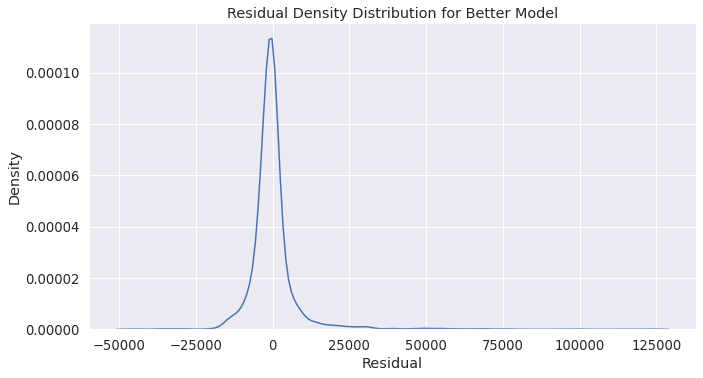

In [14]:
# Create the list of residuals using function we defined earlier
residuals = create_e_lst(x_vals.to_numpy(),y_vals.to_list(),better_model)

# Density plot
sns.set_theme(style='darkgrid', font_scale = 1.2)
tt = "Residual Density Distribution for Better Model"
g = sns.displot(data=residuals, kind="kde", height=5, aspect=2).set(title=tt)
g.set_axis_labels("Residual","Density")
plt.show()

Although the density distribution has a bell-shape that centers around 0, upon closer examination, we found out that the residuals range from -50,000 to over 100,000; furthermore, the density peak only has frequency of less than 0.00012, which suggests the residuals are not really concentrated at 0. These traits highly suggest our 'better' model is still not ideal.

While this model itself may be not as good as we expected, but how does it compare to our old model?

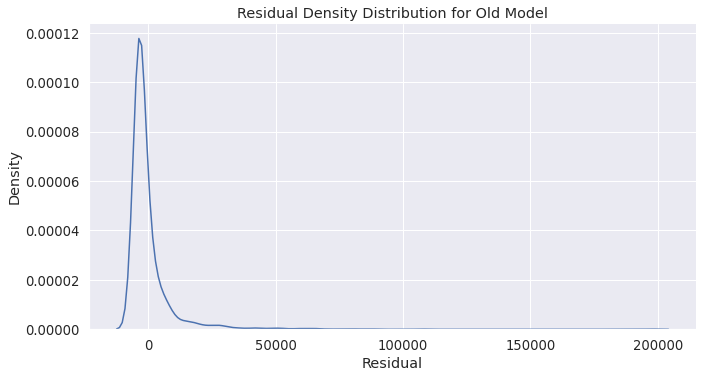

In [15]:
# Density plot using residuals from old model
tt = "Residual Density Distribution for Old Model"
g = sns.displot(data=e_lst, kind="kde", height=5, aspect=2).set(title=tt)
g.set_axis_labels("Residual","Density")
plt.show()

We can see the residual density distribution in our old model ranges from -10,000 to over 200,000 and the density does not peak at 0 though the frequency of the peak seems to be higher than that of the 'better' version. Since the x-axis of the residual has a large unit, a small deviation on the graph could be thousands a part in numbers, the center of the bell in this graph may be in negative thousands. 

In conclusion, although both models are not accurately predicting the sales, I would propose that the 'better' model is indeed better than the first model in minimizing overall errors.

# Machine Learning

Unfortunately, we didn't successfully create a linear regression model that is capable of accurately predicting anime DVD sales based on year, studio, and source. Even so, there're other works to be done.

We all know how amazing YouTube algorithm is at recommending you videos that you never thought you would like to watch. I want to develop a recommending system for anime built on DVD/Blu-ray sales. It may seems strange that anyone would choose which show to watch based on DVD sales, but for us enthusiasts such a system is dream come true.

## K-Means

One machine learning technique that could help us build the recommendation system is K-Means. 

Imagine we have a number of points on a graph, and we want to categorize the points into k clusters. We would find k 'mean points' that are at the center of each cluster such that all points on the graph are close to at least one cluster. 

It is easy to visualize if we have a set of data that exists on a 2D graph. However, the data we are working with, the anime DVD sales, only has dimension of 1. If only there's a way to transform a 1D data to 2D...

This is where the tedious work of creating linear regression model we have done before comes to shine. Remember for each entry of data we have an error, residual, under the linear regression model. We can think of the residual as a dimension which indicates how far the sales deviate from its prediction value. Adding the axis of residual to the axis of DVD sales, which indicates the actual sales, we can create a set of 2D data that epitomize the properties of anime DVD sales.

Before we start applying k means to the data, let's see how this 2D data looks after transformation.

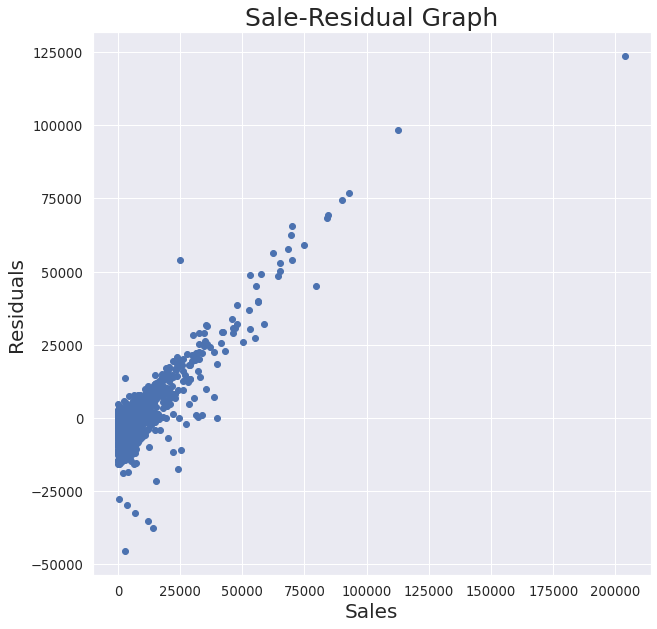

In [16]:
# Plot using sales and residuals
# Define sales list, residual list defined ealier
sales_list = as_aft_1995['Total'].to_list()
# Initialize graph
fig, ax = plt.subplots()
# Set graph size
fig.set_size_inches(10, 10)
# Plot the graph
ax.scatter(sales_list, residuals)
# Set lables
ax.set_xlabel('Sales', fontsize=20)
ax.set_ylabel('Residuals', fontsize=20)
ax.set_title('Sale-Residual Graph', fontsize=25)
plt.show() 

This graph looks nice enough. Through a simple visual inspection I would say there are 4-5 clusters of points, but we wish a rigorous method to find the number of k that accurately distinguishes the clusters. 

## K-Means++

The most straightforward way is to try some k for number of clusters and record the loss for each k. If we line plot the loss against k we can check visually for the minimum k value that reduces the loss to an acceptable level. This process is also called k-means++.

We will be using, as always, the `sklearn` library for the construction of k means model, you can see its documentation at https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html.

In [17]:
# This function takes in two list and create a list of lists where
# each element is a point in a graph
def create_2d(x_vals, y_vals):
    i = 0
    coor_lst = []
    while i < len(x_vals):
        coor_lst.append([x_vals[i], y_vals[i]])
        i += 1
        
    return coor_lst

# Create a list of points using sales and residuals
sales_2D = create_2d(sales_list,residuals)

# Check k for 2 to 100
loss_list = []
for i in range(2,101):
    # Construct a K-means model using sklearn
    kmeans = KMeans(n_clusters=i).fit(sales_2D)
    # inertia_ attribute returns the loss, add loss to list
    loss_list.append(kmeans.inertia_)

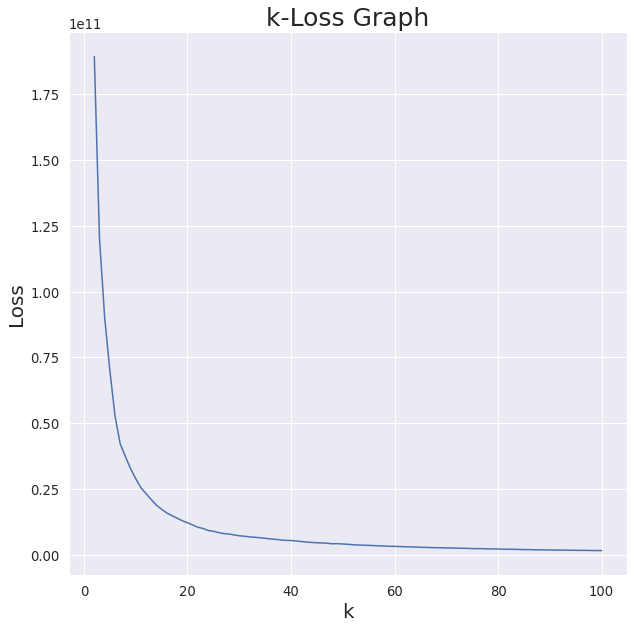

In [18]:
# Initialize graph
fig, ax = plt.subplots()
# Set graph size
fig.set_size_inches(10, 10)
# Plot the graph
ax.plot(range(2,101), loss_list)
# Set lables
ax.set_xlabel('k', fontsize=20)
ax.set_ylabel('Loss', fontsize=20)
ax.set_title('k-Loss Graph', fontsize=25)
plt.show() 

On the graph above, it seems the loss is greatly reduced when $k \geq 20$. 

So, for our model, we will choose $k = 20$ as the number of clusters. 

Let's create it and visualize the clusters on a graph to see what they look like.

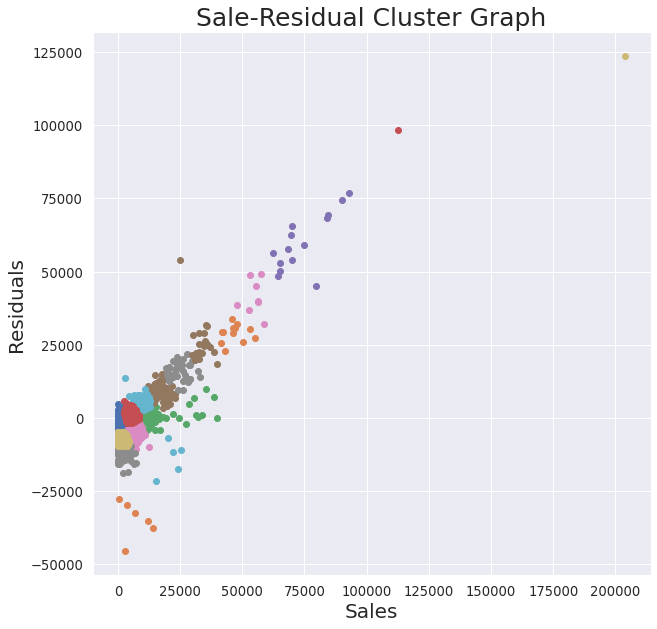

In [19]:
# This is our final k-means model
# The model would fit each sale-residual point to a label,
# which indicates which cluster the point is in
kmeans = KMeans(n_clusters=20).fit(sales_2D)
# Get the labels for each entry 
label = kmeans.fit_predict(sales_2D)
# Create a dataframe that includes sales, residuals, and their corresponding labels
df = pd.DataFrame(data={'sales':sales_list,'residual':residuals,'label':label})

# Using unique() to get the unique values of labels,
# which later is used to mark color
u_labels = np.unique(label) 
# Initialize graph
fig, ax = plt.subplots()
# Set graph size
fig.set_size_inches(10, 10)
# Plot the graph
for i in u_labels:
    filtered = df[label == i]
    plt.scatter(filtered['sales'], filtered['residual'], label = i)
# Set lables
ax.set_xlabel('Sales', fontsize=20)
ax.set_ylabel('Residuals', fontsize=20)
ax.set_title('Sale-Residual Cluster Graph', fontsize=25)
plt.show() 

On this graph we can see the k-means method successfully categorizes the sale-residual points into 20 different clusters, and each cluster looks fair. Notice the plotting does not have enough default color for all 20 labels so there's some overlaps between them, but it is hardly an issue as we can distinguish clusters just fine.

## Final Recommendation System

After finishing the construction of k-means model, we can finally move on to create the recommendation system we longed for.

Given a sale-residual pair, we can simply use our k-means model to predict its label, then use this label to match and find other anime with the same label.

In [20]:
# Make a copy of our original data frame so things here
# does not mess up
as_rec_sys = as_aft_1995.copy()
# Add label as a column so we and search the dataframe by label
as_rec_sys['Anime Label'] = label

# Function that takes in values for sale and residual
# print out other titles of anime that is recommended based on
# the k-means model we developed
def recom_sys(sale, residual, model, df):
    # Predict using k-means
    X = [sale, residual]
    lb = model.predict([X])
    # find entries corresponding to predicted title
    filtered = df[(df['Anime Label'] == lb[0])]
    # sample some entries, get the titles and print out
    print('You may also like: ')
    for index, row in filtered.sample(n = 3).iterrows():
        print(row['Title'])

The function we defined above is the final function that drives the recommendation system.

Say I like an anime that sells 100,000 copies of DVDs and has 40,000 of residual in linear regression, let's see what shows our recommendation system will recommend me.

In [28]:
recom_sys(100000, 40000, kmeans, as_rec_sys)

You may also like: 
Love Live! 2nd Season
Kidou Senshi Gundam SEED DESTINY
Mahou Shoujo Madoka Magica


# Conclusion 

## Insights Attained

Through the course of this tutorial, we smoothly organized and integrated the datasets obtained using web-scrapping techniques, sufficiently explored and visualized the data using graphs, and adopted a few machine learning methods to design experiments aiming to construct dependable prediction model.

While we failed to reject the null hypothesis for our linear regression model, rendering our attempt to predict anime DVD sales with year, studio, and source unsuccessful; we utilized the data acquired in the linear regression step, combined with our employment of k-means, to victoriously design an anime recommendation system for DVD sales.

Our failed attempt to predict anime DVD sales with year, studio, and source suggests we are unable to find a linear relationship between them. This is coherent with the factual knowledge I have about the anime industry that the anime DVD sales are oriented by a power beyond mankind's imagination (we enthusiasts usually call it *Force Regia*).

Our successful effort to design the recommendation system tells us that it is possible to categorize anime based on DVD sales and residuals under linear regression, the latter itself is calculated under sales, year, studio, and source. This observation has a great implication that despite the unfortunate reality that the model itself is inaccurate in predicting sales, the residual for each of its prediction reflects the properties of an anime, which in a way is converting year, studio, and source from abstract types to quantifiable values. It is by using these values we are able to construct the final recommendation system.

## Learn More About Data Science

* One topic I really like but didn't incorporate into this tutorial is Natural Language Processing. If you want to know more about that, you can watch Stanford lectures on YouTube https://youtu.be/8rXD5-xhemo . 

* Hypothesis testing is one of the hardest topic in my opinion, there are lectures about on Khan Academy, at https://www.khanacademy.org/math/statistics-probability/significance-tests-one-sample .

* *Lionbridge AI* is an online school that teaches AL, machine learning, and other stuff. If you are interested in these topics, find out more at https://lionbridge.ai/ .

* If you want to try data analysis yourself, there's a list of 50 datasets for you to work on https://lionbridge.ai/datasets/the-50-best-free-datasets-for-machine-learning/ .

